In [25]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from sklearn.svm import SVC

from scipy.stats import ttest_ind_from_stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import itertools

%matplotlib inline

In [14]:
df = pd.read_csv("mini_mnist.csv")
X = df.values[:,:-1] # features
y = df.values[:,-1] # target

X.shape, y.shape

((1500, 784), (1500,))

In [15]:
pca = PCA(n_components=2)  
pca.fit(X)
X_pca = pca.transform(X)

In [16]:
df2 = pd.DataFrame(X_pca, columns=['PC 0', 'PC 1'])
df2['digito'] = y
df2.head()

,PC 0,PC 1,digito
0,-20.609676,-826.403629,7
1,340.017123,97.234529,8
2,-103.103157,324.517473,2
3,-532.463102,-326.999125,9
4,-31.239514,34.762246,5


<Axes: xlabel='PC 0', ylabel='PC 1'>

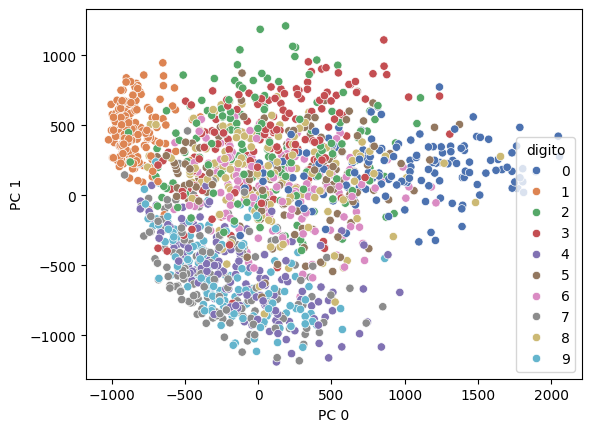

In [17]:
sns.scatterplot(data=df2, x='PC 0', y='PC 1', hue='digito', palette='deep')

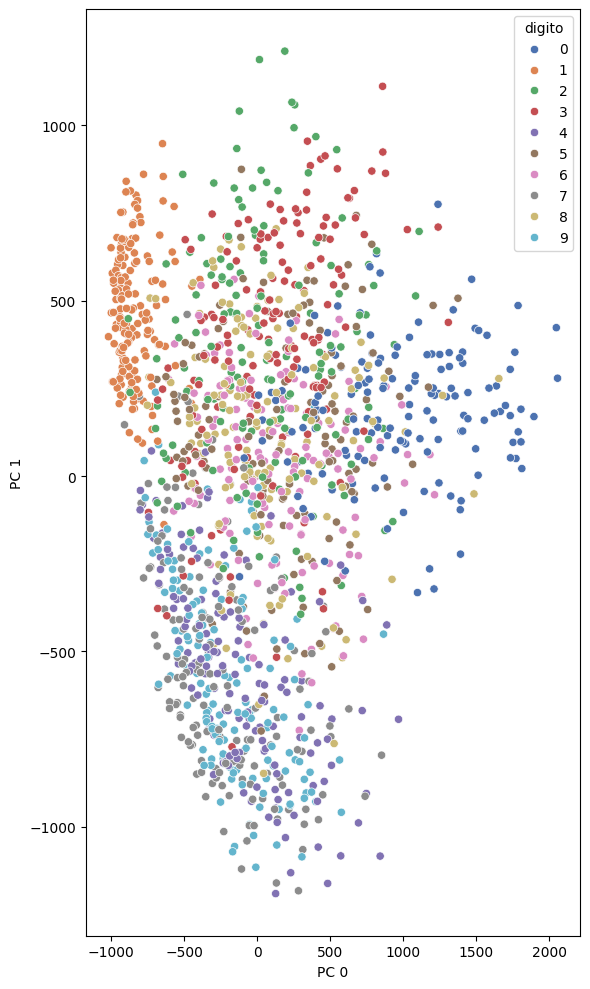

In [18]:
fig, ax = plt.subplots(figsize=(6,10))
sns.scatterplot(data=df2, x='PC 0', y='PC 1', hue='digito', palette='deep', ax=ax)
fig.tight_layout()

In [19]:
def selecionar_melhor_k(ks, X_treino, X_val, y_treino, y_val):
    acuracias_val = []

    for k in ks:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_treino, y_treino)
        pred = knn.predict(X_val)
        acuracias_val.append(accuracy_score(y_val, pred))

    melhor_val = max(acuracias_val)
    melhor_k = ks[np.argmax(acuracias_val)]
    knn = KNeighborsClassifier(n_neighbors=melhor_k)
    knn.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val])

    return knn, melhor_k, melhor_val

In [20]:
#a validação cruzada será realizada em 10 vias.
k_vias = 10

#usar o protocolo de validação cruzada estratificada
skf = StratifiedKFold(n_splits=k_vias, shuffle=True, random_state=1)

acuracias = []

#a função split retorna os índices das instâncias que devem ser usadas para o treinamento e o teste.
for idx_treino, idx_teste in skf.split(X, y):

    #extrair as instâncias de treinamento de acordo com os índices fornecidos pelo skf.split
    X_treino = X[idx_treino]
    y_treino = y[idx_treino]

    #extrair as instâncias de teste de acordo com os índices fornecidos pelo skf.split
    X_teste = X[idx_teste]
    y_teste = y[idx_teste]

    #separar as instâncias de treinamento entre treinamento e validação para a otimização do hiperparâmetro k
    X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, test_size=0.2, stratify=y_treino, shuffle=True, random_state=1)

    #colocar todas as variáveis na mesma escala, usando o conjunto de treinamento para calcular os parâmetros da escala
    ss = StandardScaler()
    ss.fit(X_treino)
    X_treino = ss.transform(X_treino)
    X_teste = ss.transform(X_teste)
    X_val = ss.transform(X_val)

    #escolher o k com o melhor resultado no conjunto de validação e treinar o KNN com o melhor k.
    knn, _, _ = selecionar_melhor_k(range(1,30,2), X_treino, X_val, y_treino, y_val)

    #calcular a acurácia no conjunto de testes desta iteração e salvar na lista.
    acuracias.append(accuracy_score(y_teste, knn.predict(X_teste)))

#calcular as estatísticas da validação cruzada. Estas estatísticas nos dão uma confiança que, na média, este é o desempenho esperado
#do classificador no mundo real.
print("min: %.2f, max: %.2f, avg +- std: %.2f+-%.2f" % (min(acuracias), max(acuracias), np.mean(acuracias), np.std(acuracias)))

accs_knn = acuracias

min: 0.80, max: 0.89, avg +- std: 0.84+-0.03


In [21]:
def calcular_estatisticas(resultados):
    return np.mean(resultados), np.std(resultados), np.min(resultados), np.max(resultados)

def imprimir_estatisticas(resultados):
    media, desvio, mini, maxi = calcular_estatisticas(resultados)
    print("Resultados: %.2f +- %.2f, min: %.2f, max: %.2f" % (media, desvio, mini, maxi))

In [22]:
#Cs e gammas são listas com os valores a serem avaliados para os respectivos parâmetros.
def selecionar_melhor_svm(Cs, gammas, X_treino : np.ndarray, X_val : np.ndarray, 
                          y_treino : np.ndarray, y_val : np.ndarray, n_jobs=4):
    
    def treinar_svm(C, gamma, X_treino, X_val, y_treino, y_val):
        svm = SVC(C=C, gamma=gamma)
        svm.fit(X_treino, y_treino)
        pred = svm.predict(X_val)
        return accuracy_score(y_val, pred)
    
    #gera todas as combinações de parametros C e gamma, de acordo com as listas de valores recebidas por parametro.
    #Na prática faz o produto cartesiano entre Cs e gammas.
    combinacoes_parametros = list(itertools.product(Cs, gammas))
    
    #Treinar modelos com todas as combinações de C e gamma
    acuracias_val = Parallel(n_jobs=n_jobs)(delayed(treinar_svm)
                                       (c, g, X_treino, X_val, y_treino, y_val) for c, g in combinacoes_parametros)       
    
    melhor_val = max(acuracias_val)
    #Encontrar a combinação que levou ao melhor resultado no conjunto de validação
    melhor_comb = combinacoes_parametros[np.argmax(acuracias_val)]   
    melhor_c = melhor_comb[0]
    melhor_gamma = melhor_comb[1]
    
    #Treinar uma SVM com todos os dados de treino e validação usando a melhor combinação de C e gamma.
    svm = SVC(C=melhor_c, gamma=melhor_gamma)
    svm.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val])

    return svm, melhor_comb, melhor_val

#Implementa a validação cruzada para avaliar o desempenho da SVM na base de dados com as instâncias X e as saídas y.
#cv_splits indica o número de partições que devem ser criadas.
#Cs é a lista com os valores C que devem ser avaliados na busca exaustiva de parametros para a SVM.
#gammas s é a lista com os valores gamma que devem ser avaliados na busca exaustiva de parametros para a SVM.
def do_cv_svm(X, y, cv_splits, Cs=[1], gammas=['scale']):

    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=1)

    acuracias = []
    
    pgb = tqdm(total=cv_splits, desc='Folds avaliados')
    
    for treino_idx, teste_idx in skf.split(X, y):

        X_treino = X[treino_idx]
        y_treino = y[treino_idx]

        X_teste = X[teste_idx]
        y_teste = y[teste_idx]

        X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, stratify=y_treino, test_size=0.2, random_state=1)

        ss = StandardScaler()
        ss.fit(X_treino)
        X_treino = ss.transform(X_treino)
        X_teste = ss.transform(X_teste)
        X_val = ss.transform(X_val)

        svm, _, _ = selecionar_melhor_svm(Cs, gammas, X_treino, X_val, y_treino, y_val)
        pred = svm.predict(X_teste)

        acuracias.append(accuracy_score(y_teste, pred))
        
        pgb.update(1)
        
    pgb.close()
    
    return acuracias

In [23]:
accs_svm = do_cv_svm(X, y, 10, Cs=[1, 10, 100, 1000], gammas=['scale', 'auto', 2e-2, 2e-3, 2e-4])

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

In [24]:
print("\nEstatísticas KNN")
imprimir_estatisticas(accs_knn)

print("\nEstatísticas SVM")
imprimir_estatisticas(accs_svm)


Estatísticas KNN
Resultados: 0.84 +- 0.03, min: 0.80, max: 0.89

Estatísticas SVM
Resultados: 0.88 +- 0.02, min: 0.84, max: 0.91


In [26]:
media_knn, std_knn, _, _ = calcular_estatisticas(accs_knn)
media_svm, std_svm, _, _ = calcular_estatisticas(accs_svm)

#calcular o pvalor usando o teste t de Student para duas amostras independentes
_, pvalor = ttest_ind_from_stats(media_knn, std_knn, len(accs_knn), media_svm, std_svm, len(accs_svm))

In [27]:
def rejeitar_hip_nula(media_amostral1, desvio_padrao_amostral1, n1, media_amostral2, desvio_padrao_amostral2, n2, alpha=0.05):
    _, pvalor = ttest_ind_from_stats(media_amostral1, desvio_padrao_amostral1, n1, media_amostral2, desvio_padrao_amostral2, n2)
    return pvalor <= alpha

In [28]:
rejeitar_hip_nula(media_knn, std_knn, len(accs_knn), media_svm, std_svm, len(accs_svm))

True